In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras import backend as K
import shutil
import imutils
import random
import seaborn as sns
from keras import layers
from keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix,plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.applications import VGG16
import itertools
from tensorflow.keras.layers import Flatten, Conv2D, Concatenate, MaxPooling2D, ZeroPadding2D, concatenate, Input, Reshape, GlobalAveragePooling2D, Dense, Dropout, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D

## Cross val


In [3]:
''' calibrated categorical focal loss'''

def categorical_focal_loss_fixed(y_true, y_pred, alpha = 1.0, gamma = 2.0):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))  

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True
            )

valid_datagen = ImageDataGenerator()

In [5]:
train_dir = '/content/gdrive/MyDrive/Inbreast-valCross/train'
# valid_dir = '/content/gdrive/MyDrive/Inbrest-dataset/valid'
test_dir = '/content/gdrive/MyDrive/Inbreast-valCross/test'

In [18]:
images_paths = glob.glob(train_dir+'/**/*.png')

In [20]:
images = []
labels = []

for i in images_paths:
    img = cv2.imread(i,1)
    img = cv2.resize(img,(224,224))
    images.append(img)
    if 'abnormal' in i:
      labels.append(1)
    else:
      labels.append(0)  

In [23]:
images_paths_test = glob.glob(test_dir+'/**/*.png')

In [24]:
images_test = []
labels_test = []

for i in images_paths_test:
    img = cv2.imread(i,1)
    img = cv2.resize(img,(224,224))
    images_test.append(img)
    if 'abnormal' in i:
      labels_test.append(1)
    else:
      labels_test.append(0)  

In [40]:
x = np.array(images)
y = np.array(labels)

y = to_categorical(y, num_classes=2, dtype='float32')

In [41]:
x.shape

(196, 224, 224, 3)

In [26]:
x_test = np.array(images_test)
y_test = np.array(labels_test)

y_test = to_categorical(y_test, num_classes=2, dtype='float32')

the model


In [29]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [32]:
from tensorflow.keras.models import Model,load_model
model = load_model('/content/gdrive/MyDrive/Segmentation_model/resenet_unet_segmentation.hdf5',
                   custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
# model.trainable = False

# for i in model.layers:
#     if 'stage4_unit' in i.name:
#         i.trainable = True

# for i in model.layers:
#     if 'decoder' in i.name:
#         i.trainable = True        
# model.summary()
base_model=Model(inputs=model.input,
                        outputs=model.get_layer('decoder_stage4b_conv').output)
x = base_model.output 
x = ZeroPadding2D()(x)
x = Conv2D(32,(3,3), activation='relu', name = 'extra_conv_resnet') (x)
x = GlobalAveragePooling2D()(x) 
logits = Dense(2, 
              activation='softmax', 
              name='predictions')(x)

In [11]:
filepath = '/content/gdrive/MyDrive/CrossVal/Crossval_categorical_focal_loss_fixed.{epoch:02d}-{val_accuracy:.4f}.h5'
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, 
                             save_weights_only=False, 
                             save_best_only=True, 
                             mode='max', 
                             save_freq='epoch')
earlyStopping = EarlyStopping(monitor='val_accuracy', 
                              patience=40, 
                              verbose=1, 
                              mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=5,
                              verbose=1,
                              mode='max')
callbacks_list = [checkpoint]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 1 ...

Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to /content/drive/MyDrive/weights/Training for fold 1 _satge4trained_categorical_focal_loss_fixed.01-0.6000.h5

Epoch 2: val_accuracy did not improve from 0.60000

Epoch 3: val_accuracy did not improve from 0.60000

Epoch 4: val_accuracy improved from 0.60000 to 0.75000, saving model to /content/drive/MyDrive/weights/Training for fold 1 _satge4trained_categorical_focal_loss_fixed.04-0.7500.h5

Epoch 5: val_accuracy did not improve from 0.75000

Epoch 6: val_accuracy did not improve from 0.75000

Epoch 7: val_accuracy did not improve from 0.75000

Epoch 8: val_accuracy did not improve from 0.75000

Epoch 9: val_accuracy did not improve from 0.75000

Epoch 10: val_accuracy did not improve from 0.75000

Epoch 11: val_accuracy improved from 0.75000 to 0.80000, saving model to /content/drive/MyDrive/weights/Training for fold 1 _s

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 2 ...

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/weights/Training for fold 2 _satge4trained_categorical_focal_loss_fixed.01-0.5000.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: val_accuracy improved from 0.50000 to 0.55000, saving model to /content/drive/MyDrive/weights/Training for fold 2 _satge4trained_categorical_focal_loss_fixed.04-0.5500.h5

Epoch 5: val_accuracy did not improve from 0.55000

Epoch 6: val_accuracy improved from 0.55000 to 0.70000, saving model to /content/drive/MyDrive/weights/Training for fold 2 _satge4trained_categorical_focal_loss_fixed.06-0.7000.h5

Epoch 7: val_accuracy did not improve from 0.70000

Epoch 8: val_accuracy did not improve from 0.70000

Epoch 9: val_accuracy did not improve from 0.70000

Epoch 10: val_accuracy did not improve from 0.7000

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 3 ...

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/weights/Training for fold 3 _satge4trained_categorical_focal_loss_fixed.01-0.5000.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: val_accuracy improved from 0.50000 to 0.60000, saving model to /content/drive/MyDrive/weights/Training for fold 3 _satge4trained_categorical_focal_loss_fixed.03-0.6000.h5

Epoch 4: val_accuracy did not improve from 0.60000

Epoch 5: val_accuracy improved from 0.60000 to 0.75000, saving model to /content/drive/MyDrive/weights/Training for fold 3 _satge4trained_categorical_focal_loss_fixed.05-0.7500.h5

Epoch 6: val_accuracy did not improve from 0.75000

Epoch 7: val_accuracy improved from 0.75000 to 0.80000, saving model to /content/drive/MyDrive/weights/Training for fold 3 _satge4trained_categorical_focal_loss_fixed.07-0.8000.h5

Epoch 8: val_accuracy imp

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 4 ...

Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to /content/drive/MyDrive/weights/Training for fold 4 _satge4trained_categorical_focal_loss_fixed.01-0.4500.h5

Epoch 2: val_accuracy improved from 0.45000 to 0.60000, saving model to /content/drive/MyDrive/weights/Training for fold 4 _satge4trained_categorical_focal_loss_fixed.02-0.6000.h5

Epoch 3: val_accuracy did not improve from 0.60000

Epoch 4: val_accuracy did not improve from 0.60000

Epoch 5: val_accuracy did not improve from 0.60000

Epoch 6: val_accuracy improved from 0.60000 to 0.80000, saving model to /content/drive/MyDrive/weights/Training for fold 4 _satge4trained_categorical_focal_loss_fixed.06-0.8000.h5

Epoch 7: val_accuracy did not improve from 0.80000

Epoch 8: val_accuracy did not improve from 0.80000

Epoch 9: val_accuracy improved from 0.80000 to 0.85000, saving model to /content/drive/MyDrive/weights

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 5 ...

Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to /content/drive/MyDrive/weights/Training for fold 5 _satge4trained_categorical_focal_loss_fixed.01-0.3000.h5

Epoch 2: val_accuracy improved from 0.30000 to 0.35000, saving model to /content/drive/MyDrive/weights/Training for fold 5 _satge4trained_categorical_focal_loss_fixed.02-0.3500.h5

Epoch 3: val_accuracy did not improve from 0.35000

Epoch 4: val_accuracy improved from 0.35000 to 0.40000, saving model to /content/drive/MyDrive/weights/Training for fold 5 _satge4trained_categorical_focal_loss_fixed.04-0.4000.h5

Epoch 5: val_accuracy improved from 0.40000 to 0.45000, saving model to /content/drive/MyDrive/weights/Training for fold 5 _satge4trained_categorical_focal_loss_fixed.05-0.4500.h5

Epoch 6: val_accuracy improved from 0.45000 to 0.50000, saving model to /content/drive/MyDrive/weights/Training for fold 5 _satge

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 6 ...

Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to /content/drive/MyDrive/weights/Training for fold 6 _satge4trained_categorical_focal_loss_fixed.01-0.5500.h5

Epoch 2: val_accuracy did not improve from 0.55000

Epoch 3: val_accuracy did not improve from 0.55000

Epoch 4: val_accuracy did not improve from 0.55000

Epoch 5: val_accuracy improved from 0.55000 to 0.60000, saving model to /content/drive/MyDrive/weights/Training for fold 6 _satge4trained_categorical_focal_loss_fixed.05-0.6000.h5

Epoch 6: val_accuracy did not improve from 0.60000

Epoch 7: val_accuracy did not improve from 0.60000

Epoch 8: val_accuracy improved from 0.60000 to 0.70000, saving model to /content/drive/MyDrive/weights/Training for fold 6 _satge4trained_categorical_focal_loss_fixed.08-0.7000.h5

Epoch 9: val_accuracy did not improve from 0.70000

Epoch 10: val_accuracy did not improve from 0.7000

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 7 ...

Epoch 1: val_accuracy improved from -inf to 0.52632, saving model to /content/drive/MyDrive/weights/Training for fold 7 _satge4trained_categorical_focal_loss_fixed.01-0.5263.h5

Epoch 2: val_accuracy did not improve from 0.52632

Epoch 3: val_accuracy did not improve from 0.52632

Epoch 4: val_accuracy improved from 0.52632 to 0.68421, saving model to /content/drive/MyDrive/weights/Training for fold 7 _satge4trained_categorical_focal_loss_fixed.04-0.6842.h5

Epoch 5: val_accuracy did not improve from 0.68421

Epoch 6: val_accuracy did not improve from 0.68421

Epoch 7: val_accuracy did not improve from 0.68421

Epoch 8: val_accuracy did not improve from 0.68421

Epoch 9: val_accuracy did not improve from 0.68421

Epoch 10: val_accuracy improved from 0.68421 to 0.73684, saving model to /content/drive/MyDrive/weights/Training for fold 7 _satge4trained_categorical_focal_loss_fixed.10-0.7368.h

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_

------------------------------------------------------------------------
Training for fold 8 ...

Epoch 1: val_accuracy improved from -inf to 0.68421, saving model to /content/drive/MyDrive/weights/Training for fold 8 _satge4trained_categorical_focal_loss_fixed.01-0.6842.h5

Epoch 2: val_accuracy did not improve from 0.68421

Epoch 3: val_accuracy did not improve from 0.68421

Epoch 4: val_accuracy did not improve from 0.68421

Epoch 5: val_accuracy did not improve from 0.68421

Epoch 6: val_accuracy did not improve from 0.68421

Epoch 7: val_accuracy did not improve from 0.68421

Epoch 8: val_accuracy did not improve from 0.68421

Epoch 9: val_accuracy did not improve from 0.68421

Epoch 10: val_accuracy did not improve from 0.68421

Epoch 11: val_accuracy did not improve from 0.68421

Epoch 12: val_accuracy did not improve from 0.68421

Epoch 13: val_accuracy did not improve from 0.68421

Epoch 14: val_accuracy improved from 0.68421 to 0.78947, saving model to /content/drive/MyDrive/

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 9 ...

Epoch 1: val_accuracy improved from -inf to 0.57895, saving model to /content/drive/MyDrive/weights/Training for fold 9 _satge4trained_categorical_focal_loss_fixed.01-0.5789.h5

Epoch 2: val_accuracy did not improve from 0.57895

Epoch 3: val_accuracy did not improve from 0.57895

Epoch 4: val_accuracy did not improve from 0.57895

Epoch 5: val_accuracy did not improve from 0.57895

Epoch 6: val_accuracy did not improve from 0.57895

Epoch 7: val_accuracy did not improve from 0.57895

Epoch 8: val_accuracy did not improve from 0.57895

Epoch 9: val_accuracy did not improve from 0.57895

Epoch 10: val_accuracy improved from 0.57895 to 0.63158, saving model to /content/drive/MyDrive/weights/Training for fold 9 _satge4trained_categorical_focal_loss_fixed.10-0.6316.h5

Epoch 11: val_accuracy did not improve from 0.63158

Epoch 12: val_accuracy did not improve from 0.63158

Epoch 13: val_accura

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 10 ...

Epoch 1: val_accuracy improved from -inf to 0.52632, saving model to /content/drive/MyDrive/weights/Training for fold 10 _satge4trained_categorical_focal_loss_fixed.01-0.5263.h5

Epoch 2: val_accuracy did not improve from 0.52632

Epoch 3: val_accuracy did not improve from 0.52632

Epoch 4: val_accuracy improved from 0.52632 to 0.68421, saving model to /content/drive/MyDrive/weights/Training for fold 10 _satge4trained_categorical_focal_loss_fixed.04-0.6842.h5

Epoch 5: val_accuracy did not improve from 0.68421

Epoch 6: val_accuracy did not improve from 0.68421

Epoch 7: val_accuracy did not improve from 0.68421

Epoch 8: val_accuracy did not improve from 0.68421

Epoch 9: val_accuracy did not improve from 0.68421

Epoch 10: val_accuracy did not improve from 0.68421

Epoch 11: val_accuracy did not improve from 0.68421

Epoch 12: val_accuracy improved from 0.68421 to 0.78947, saving model 

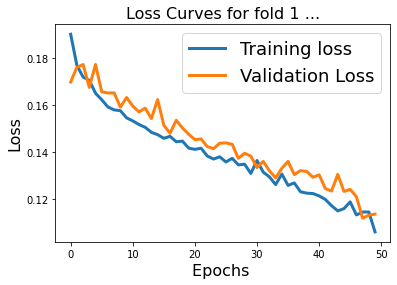

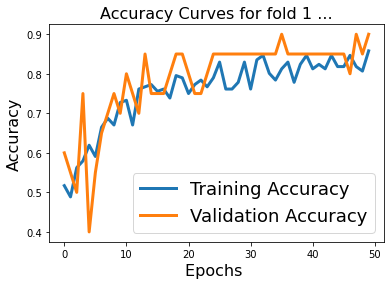

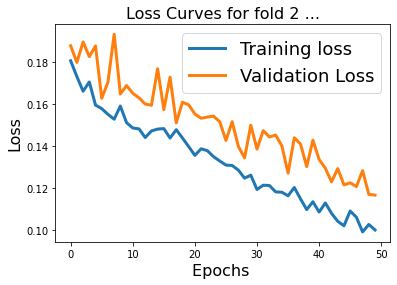

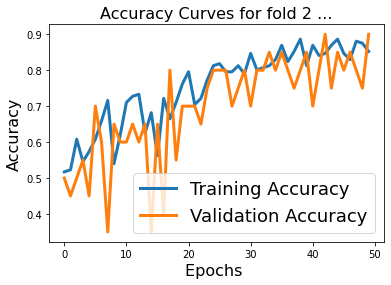

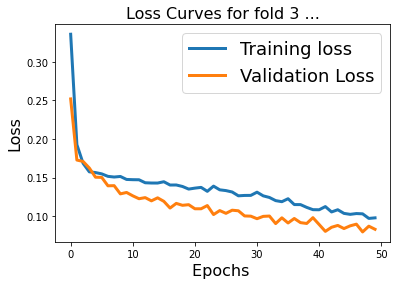

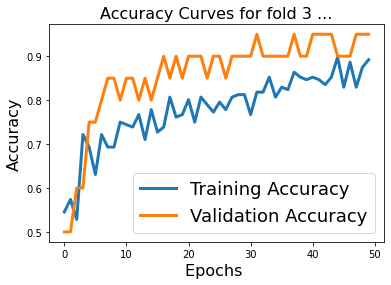

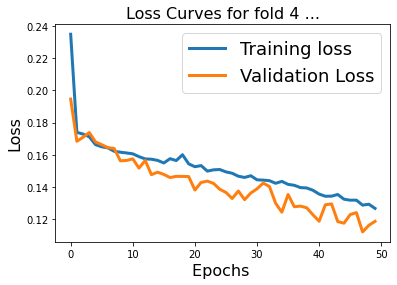

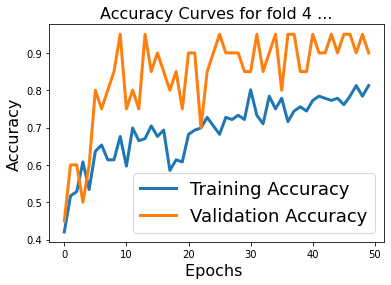

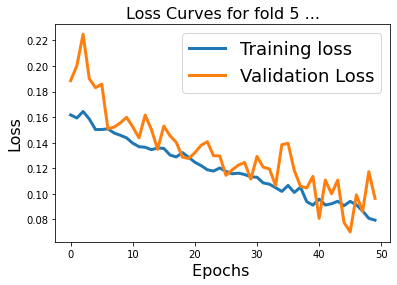

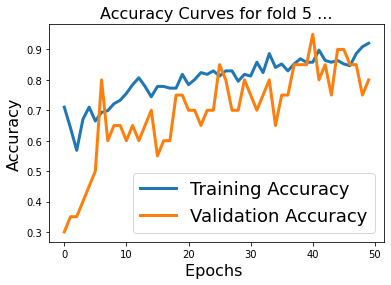

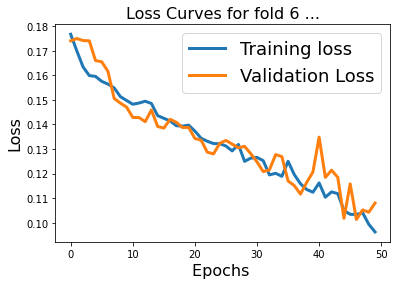

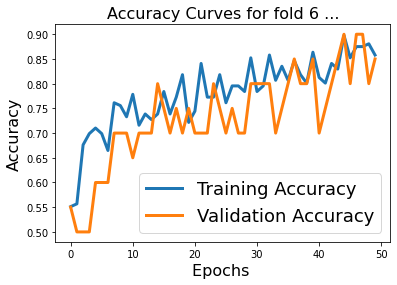

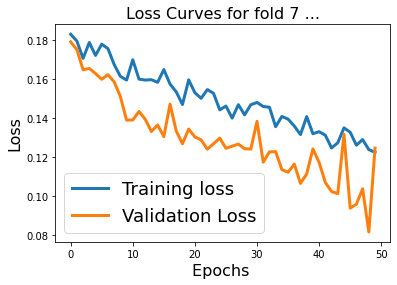

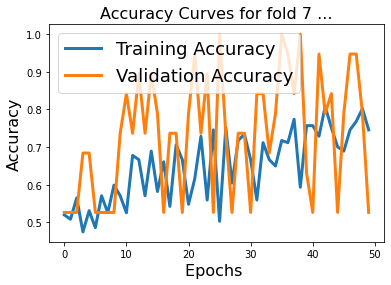

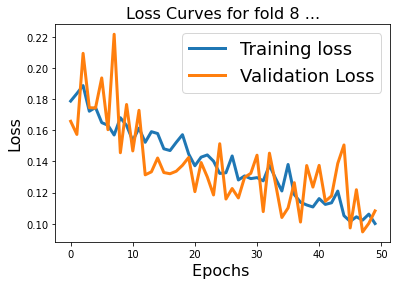

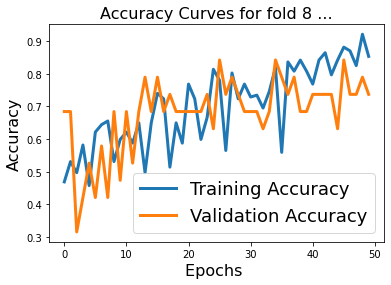

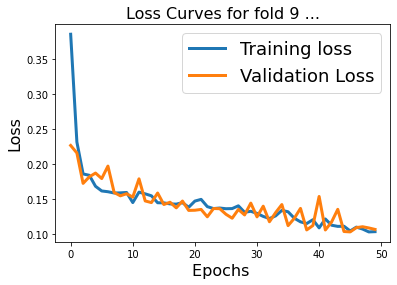

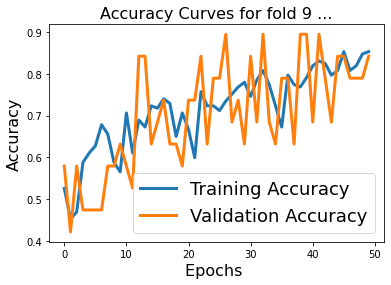

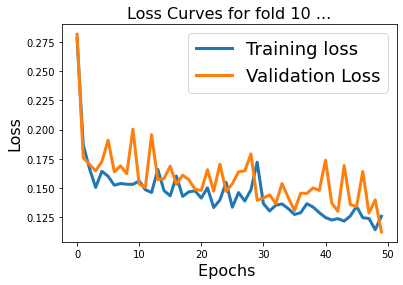

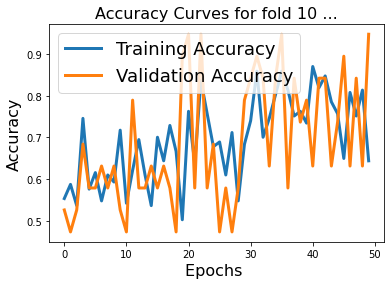

In [52]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.losses import sparse_categorical_crossentropy
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import f1_score, cohen_kappa_score, precision_score, recall_score, classification_report, log_loss, confusion_matrix, accuracy_score 
import numpy as np

# Model configuration
batch_size = 22
no_epochs = 50
# optimizer = Adam()
verbosity = 0
num_folds = 10

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs, targets = shuffle(x,y,random_state=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True,random_state=0)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    # Define the model architecture
    model = load_model('/content/gdrive/MyDrive/Segmentation_model/resenet_unet_segmentation.hdf5',
                   custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    base_model=Model(inputs=model.input,
                            outputs=model.get_layer('decoder_stage4b_conv').output)
    x = base_model.output 
    x = ZeroPadding2D()(x)
    x = Conv2D(32,(3,3), activation='relu', name = 'extra_conv_resnet') (x)
    x = GlobalAveragePooling2D()(x) 
    logits = Dense(2, 
                  activation='softmax', 
                  name='predictions')(x)
    model_resnet = Model(inputs=base_model.input, 
                    outputs=logits, 
                    name = 'resnet_pretrained')
    filepath = f'/content/drive/MyDrive/weights/Training for fold {fold_no} '+'_satge4trained_categorical_focal_loss_fixed.{epoch:02d}-{val_accuracy:.4f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, 
                             save_weights_only=False, 
                             save_best_only=True, 
                             mode='max', 
                             save_freq='epoch')
    
    sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)  
    adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    amsgrad=True)
    model_resnet.compile(optimizer=sgd, 
                        loss= categorical_focal_loss_fixed, run_eagerly=True,  #use other losses in the same way
                        metrics=['accuracy']) 

    #Data augmentation:
    train_generator = train_datagen.flow(inputs[train], targets[train],batch_size=batch_size)
    valid_generator = train_datagen.flow(inputs[test], targets[test],batch_size=batch_size)
  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    train_generator.reset()
    valid_generator.reset()
  # Fit data to model
    history = model_resnet.fit(train_generator,
              batch_size=batch_size,
              epochs=no_epochs,
              validation_data=(valid_generator),
              verbose=verbosity,
              callbacks=[checkpoint])
    #Plot the Loss Curves
    plt.figure(figsize=[6,4])
    plt.plot(history.history['loss'],linewidth=3.0)
    plt.plot(history.history['val_loss'],linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title(f'Loss Curves for fold {fold_no} ...',fontsize=16)

    #Plot the Accuracy Curves
    plt.figure(figsize=[6,4])
    plt.plot(history.history['accuracy'],linewidth=3.0)
    plt.plot(history.history['val_accuracy'],linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title(f'Accuracy Curves for fold {fold_no} ...',fontsize=16)
  # Generate generalization metrics
    test_generator = train_datagen.flow(x_test, y_test,batch_size=batch_size)
    scores = model_resnet.evaluate(test_generator, verbose=0)
    print(f'Score for fold {fold_no}: {model_resnet.metrics_names[0]} of {scores[0]}; {model_resnet.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    custom_y_pred = model_resnet.predict(x_test)
    custom_y_pred1_label = custom_y_pred.argmax(axis=-1)

    #%%
    #save predictions to a CSV file

    predicted_class_indices=np.argmax(custom_y_pred,axis=1)
    print(predicted_class_indices)

    '''
    map the predicted labels with their unique ids such 
    as filenames to find out what you predicted for which image.
    '''

    # labels = (test_generator.class_indices)
    # labels = dict((v,k) for k,v in labels.items())
    # predictions = [labels[k] for k in predicted_class_indices]

    # #save the results to a CSV file
    # filenames=test_generator.filenames
    # results=pd.DataFrame({"Filename":filenames,
    #                       "Predictions":predicted_class_indices,
    #                       "Labels":predictions})
    target_names = ['abnormal','Normal']
    print(classification_report(y_test.argmax(axis=-1),
                                custom_y_pred.argmax(axis=-1),
                                target_names=target_names, 
                                digits=4))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test.argmax(axis=-1),
                                  custom_y_pred.argmax(axis=-1))
    print("Confusion Matrix")
    print(cnf_matrix)
      # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')